In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools

In [2]:
raw_df = pd.read_csv('../data/accre-gpu-jobs-2022-v2.csv', on_bad_lines='skip')

In [3]:
raw_df.columns = raw_df.columns.str.lower()

gpu_jobs_df = (raw_df
               .loc[raw_df['state'] == 'COMPLETED']
               .copy()
              )

gpu_jobs_df['reqtime'] = pd.to_timedelta(
    gpu_jobs_df['reqtime'].str.replace('-',' days ')
)

gpu_jobs_df['usedtime'] = pd.to_timedelta(
    gpu_jobs_df['usedtime'].str.replace('-',' days ')
)

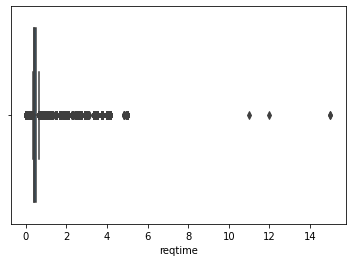

In [123]:
sns.boxplot(
    x = gpu_jobs_df['reqtime'] / np.timedelta64(1,'D')
);

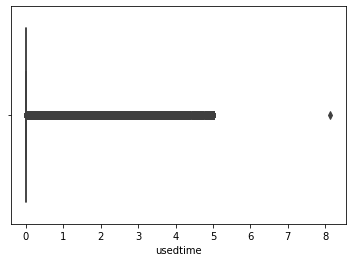

In [122]:
sns.boxplot(
    x = gpu_jobs_df['usedtime'] / np.timedelta64(1,'D')
);

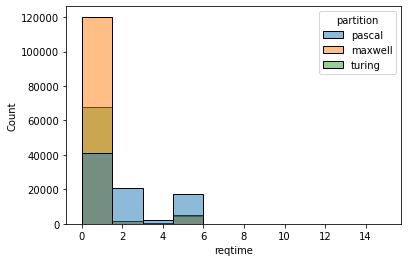

In [124]:
sns.histplot(
    x = gpu_jobs_df['reqtime'] / np.timedelta64(1,'D'),
    hue = gpu_jobs_df['partition'],
    bins = 10
);

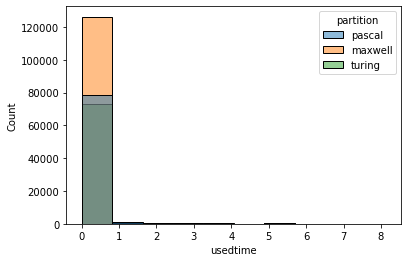

In [125]:
sns.histplot(
    x = gpu_jobs_df['usedtime'] / np.timedelta64(1,'D'),
    hue = gpu_jobs_df['partition'],
    bins = 10
);

In [6]:
def all_used_percent(percent):
    values = []
    for x in percent:
        used = gpu_jobs_df.loc[
            gpu_jobs_df['usedtime'] >= gpu_jobs_df['reqtime'] * x
        ]['jobid'].count()
    
        per = (used / gpu_jobs_df['jobid'].count() * 100).round(2)
    
        values.append(per)
    return values

In [24]:
percentages = [.9, .8, .7, .6, .01, .001, .0001]
days = ['less than', 1, 2, 3, 4, 5, 'more than']

[1.27, 1.5, 1.75, 2.05, 27.8, 77.96, 98.26]

In [8]:
def less_than_day(percent):
    values = []
    for x in percent:
        used = gpu_jobs_df.loc[
                    ((gpu_jobs_df['reqtime'] < np.timedelta64(1,'D')) &
                    (gpu_jobs_df['usedtime'] >= gpu_jobs_df['reqtime'] * x)
                    )
                ]['jobid'].count()
            
        per = (
            (used / gpu_jobs_df.loc[
                    gpu_jobs_df['reqtime'] < np.timedelta64(1,'D')
            ]['jobid'].count() * 100
            )
        ).round(2)
        values.append(per)
    return values

In [14]:
def per_day(day, percent):
    values = []
    for x in percent:
        used = gpu_jobs_df.loc[
                    ((gpu_jobs_df['reqtime'] >= np.timedelta64(day,'D')) &
                     (gpu_jobs_df['reqtime'] < np.timedelta64(day + 1,'D')) &
                    (gpu_jobs_df['usedtime'] >= gpu_jobs_df['reqtime'] * x)
                    )
                ]['jobid'].count()
        per = (
                (used / gpu_jobs_df.loc[
                    ((gpu_jobs_df['reqtime'] >= np.timedelta64(day,'D')) &
                     (gpu_jobs_df['reqtime'] < np.timedelta64(day + 1,'D'))
                    )
                ]['jobid'].count() * 100)
            ).round(2)
        values.append(per)
    return values

In [19]:
def more_than_five(percent):
    values = []
    for x in percent:
        used = gpu_jobs_df.loc[
                ((gpu_jobs_df['reqtime'] > np.timedelta64(5,'D')) &
                (gpu_jobs_df['usedtime'] >= gpu_jobs_df['reqtime'] * x)
                )
            ]['jobid'].count()
        per = (
            (used / gpu_jobs_df.loc[
                gpu_jobs_df['reqtime'] > np.timedelta64(5,'D')
            ]['jobid'].count() * 100
            )
        ).round(2)
        values.append(per)
    return values

In [107]:
percent_df = pd.DataFrame()

percent_df['percentages'] = percentages
percent_df['percentages'] = percent_df['percentages'] * 100

percent_df['all_entries'] = all_used_percent(percentages)

percent_df['less_than_day'] = less_than_day(percentages)

percent_df['one_day'] = per_day(1, percentages)
percent_df['two_days'] = per_day(2, percentages)
percent_df['three_days'] = per_day(3, percentages)
percent_df['four_days'] = per_day(4, percentages)
percent_df['five_days'] = per_day(5, percentages)

percent_df['more_than_five'] = more_than_five(percentages)

percent_df = percent_df.transpose().reset_index()
percent_df.columns = percent_df.iloc[0]
percent_df = (percent_df
              .drop(percent_df.index[0])
              .rename(columns = {'percentages' : 'req_days'})
             )

In [108]:
percent_df

,req_days,90.0,80.0,70.0,60.0,1.0,0.1,0.01
1,all_entries,1.27,1.50,1.75,2.05,27.80,77.96,98.26
2,less_than_day,0.83,1.01,1.20,1.43,25.98,77.73,99.59
3,one_day,2.63,2.97,3.08,3.30,55.22,79.53,95.77
4,two_days,1.56,1.73,1.87,2.56,20.55,67.11,88.74
5,three_days,1.61,1.65,1.75,1.84,21.03,64.00,94.23
6,four_days,10.43,10.48,11.14,11.65,23.14,77.77,92.30
7,five_days,3.37,3.99,4.94,5.79,38.57,90.64,95.37
8,more_than_five,0.00,0.00,0.00,25.00,100.00,100.00,100.00


In [112]:
gpu_jobs_df['reqtime'].describe()

count                       283333
mean     1 days 00:05:59.687223161
std      1 days 11:29:35.285143482
min                0 days 00:01:00
25%                0 days 10:00:00
50%                0 days 10:00:00
75%                0 days 12:00:00
max               15 days 00:00:00
Name: reqtime, dtype: object

In [113]:
gpu_jobs_df['usedtime'].describe()

count                       283333
mean     0 days 01:34:19.081218919
std      0 days 09:38:43.694361307
min                0 days 00:00:00
25%                0 days 00:00:22
50%                0 days 00:03:19
75%                0 days 00:09:06
max                8 days 03:15:34
Name: usedtime, dtype: object